In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

##Load in Data

In [39]:
df_test = pd.read_csv('./sample_data/mnist_test.csv')
df_train = pd.read_csv('./sample_data/mnist_train_small.csv')

##Create Digits Dataset Class

In [40]:
class DigitsDataset(torch.utils.data.Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    x = np.float32(row[1:].values) / 255    
    y = row[0]

    return x,y

##Batch the Data

In [41]:
def createBatches(batch_size):
  dataset_train = DigitsDataset(df_train)
  dataset_test = DigitsDataset(df_test)

  dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
  dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size, shuffle = True)

  return dataset_train, dataset_test, dataloader_train, dataloader_test




##Predict

In [42]:
def predict(dataloader_test, dataset_test):
  device = torch.device('cuda')
  num_correct = 0
  model1.eval()
  N_test = len(dataset_test)

  for X_batch, Y_batch in dataloader_test:

    X_batch = X_batch.to(device)
    Y_batch = Y_batch.to(device)

    with torch.no_grad():

      outputs = model1(X_batch)
      num_correct += sum(torch.argmax(outputs, axis = 1) == Y_batch)

  print('Accuracy: ', num_correct / N_test)

##Graph

In [43]:
def graph(train_losses, test_losses):
  plt.plot(train_losses, label = 'training loss')
  plt.plot(test_losses, label = 'test loss')
  plt.legend(loc = 'upper right')
  plt.title('Objective function value versus epoch')

#Neural Network

In [44]:
class SimpleNeuralNetwork(torch.nn.Module):

  def __init__(self):

    super().__init__()

    self.dense1 = torch.nn.Linear(784, 100)
    self.dense2 = torch.nn.Linear(100,10)          

    self.ReLU = torch.nn.ReLU()

  def forward(self, x):

    x = self.dense1(x)   
    x = self.ReLU(x)
    x = self.dense2(x)  

    return x

In [45]:
def myModel(epochs, lrate, batch):
  dataset_train, dataset_test, dataloader_train, dataloader_test = createBatches(batch)

  model = SimpleNeuralNetwork()
  device = torch.device('cuda')
  model = model.to(device)

  loss_fun = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lrate)  

  num_epochs = epochs
  N_train = len(dataset_train)
  N_test = len(dataset_test)

  train_losses = []
  test_losses = []

  for ep in range(num_epochs):

    model.train()
    train_loss = 0.0
    batch_idx = 0

    for X_batch, Y_batch in dataloader_train:

      X_batch = X_batch.to(device)
      Y_batch = Y_batch.to(device)

      N_batch = X_batch.shape[0]  
      outputs = model(X_batch)
      loss_oneBatch = loss_fun(outputs, Y_batch)

      model.zero_grad()
      loss_oneBatch.backward()
      optimizer.step()

      train_loss += loss_oneBatch * N_batch

    model.eval()
    test_loss = 0.0
    for X_batch, Y_batch in dataloader_test:

      X_batch = X_batch.to(device)
      Y_batch = Y_batch.to(device)

      with torch.no_grad():
        N_batch = X_batch.shape[0]
        outputs = model(X_batch)
        loss_oneBatch = loss_fun(outputs, Y_batch)
        test_loss += loss_oneBatch * N_batch

    train_losses.append(train_loss / N_train)
    test_losses.append(test_loss / N_test)

    print('epoch: ', ep, ' train loss: ', (train_loss), ' test loss: ', (test_loss))

  return model, train_losses, test_losses

#Logistic Regression

In [46]:
class MLR(torch.nn.Module):

  def __init__(self):

    super().__init__()
    self.linear = torch.nn.Linear(784, 10)

  def forward(self, x):
    outputs = self.linear(x)
    return outputs

In [47]:
def myModel2(epochs, lrate, batch):  

  dataset_train, dataset_test, dataloader_train, dataloader_test = createBatches(batch)
  logRegModel = MLR()
  device = torch.device('cuda')
  logRegModel = logRegModel.to(device)

  loss_fun = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(logRegModel.parameters(), lr = lrate)

  num_epochs = epochs
  N_train = len(dataset_train)
  N_test = len(dataset_test)

  train_losses = []
  test_losses = []

  for ep in range(num_epochs):

    logRegModel.train()
    train_loss = 0.0
    batch_idx = 0

    for X_batch, Y_batch in dataloader_train:

      X_batch = X_batch.to(device)
      Y_batch = Y_batch.to(device)

      N_batch = X_batch.shape[0]  
      outputs = logRegModel(X_batch)
      loss_oneBatch = loss_fun(outputs, Y_batch)

      logRegModel.zero_grad()
      loss_oneBatch.backward()
      optimizer.step()

      train_loss += loss_oneBatch * N_batch

    logRegModel.eval()
    test_loss = 0.0
    for X_batch, Y_batch in dataloader_test:
      
      X_batch = X_batch.to(device)
      Y_batch = Y_batch.to(device)

      with torch.no_grad():
        N_batch = X_batch.shape[0]
        outputs = logRegModel(X_batch)
        loss_oneBatch = loss_fun(outputs, Y_batch)
        test_loss += loss_oneBatch * N_batch

    train_losses.append(train_loss / N_train)
    test_losses.append(test_loss / N_test)

    print('epoch: ', ep, ' train loss: ', (train_loss), ' test loss: ', (test_loss))

  return logRegModel, train_losses, test_losses



#Main

- in the main, comment out either graph() function to view the graph of the other.
- if not, the losses of both models will be plotted in the same graph. 

In [48]:
def main():
  dataset_train, dataset_test, dataloader_train, dataloader_test = createBatches(64)

  print('Training neural network...')
  nn, train_losses, test_losses = myModel(5, 0.001, 64)
  print('Done Training!')
  print('Predicting...')
  predict(dataloader_test, dataset_test)  
  print()
  graph(train_losses, test_losses)

  print('-------------')

  print('Training multiclass logistic regression...')
  logRegModel, train_losses, test_losses = myModel2(5, 0.001, 64)
  print('Done Training!')
  print('Predicting...')
  predict(dataloader_test, dataset_test)  
  print()
  graph(train_losses, test_losses)

  

Training neural network...
epoch:  0  train loss:  tensor(11335.0840, device='cuda:0', grad_fn=<AddBackward0>)  test loss:  tensor(3023.0972, device='cuda:0')
epoch:  1  train loss:  tensor(5440.3647, device='cuda:0', grad_fn=<AddBackward0>)  test loss:  tensor(2569.0444, device='cuda:0')
epoch:  2  train loss:  tensor(4290.4639, device='cuda:0', grad_fn=<AddBackward0>)  test loss:  tensor(2064.1633, device='cuda:0')
epoch:  3  train loss:  tensor(3502.2192, device='cuda:0', grad_fn=<AddBackward0>)  test loss:  tensor(1788.1624, device='cuda:0')
epoch:  4  train loss:  tensor(2902.1897, device='cuda:0', grad_fn=<AddBackward0>)  test loss:  tensor(1656.2230, device='cuda:0')
Done Training!
Predicting...
Accuracy:  tensor(0.9653, device='cuda:0')

-------------
Training multiclass logistic regression...
epoch:  0  train loss:  tensor(16454.1152, device='cuda:0', grad_fn=<AddBackward0>)  test loss:  tensor(4662.6504, device='cuda:0')
epoch:  1  train loss:  tensor(8387.6787, device='cuda:

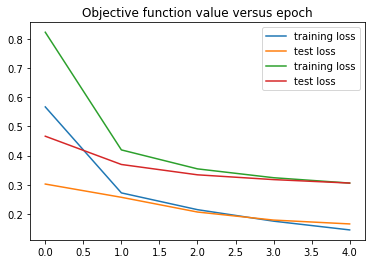

In [49]:
main()